In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from numpy import dot
from numpy.linalg import norm
from math import log
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import urllib.request
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from konlpy.tag import Okt
import urllib.request
from soynlp import DoublespaceLineCorpus
from soynlp.word import WordExtractor

# 16-2. 단어 빈도를 이용한 벡터화 Bag of Words

# 16-3. 단어 빈도를 이용한 벡터화 (2) Bag of Words 구현해보기
##  keras Tokenizer 활용

In [2]:

sentence = ["John likes to watch movies. Mary likes movies too! Mary also likes to watch football games."]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentence) # 단어장 생성
bow = dict(tokenizer.word_counts) # 각 단어와 각 단어의 빈도를 bow에 저장

print("Bag of Words :", bow) # bow 출력
print('단어장(Vocabulary)의 크기 :', len(tokenizer.word_counts)) # 중복을 제거한 단어들의 개수

Bag of Words : {'john': 1, 'likes': 3, 'to': 2, 'watch': 2, 'movies': 2, 'mary': 2, 'too': 1, 'also': 1, 'football': 1, 'games': 1}
단어장(Vocabulary)의 크기 : 10


## scikit-learn CountVectorizer 활용

In [3]:

sentence = ["John likes to watch movies. Mary likes movies too! Mary also likes to watch football games."]

vector = CountVectorizer()
bow = vector.fit_transform(sentence).toarray()

print('Bag of Words : ', bow) # 코퍼스로부터 각 단어의 빈도수를 기록한다.
print('각 단어의 인덱스 :', vector.vocabulary_) # 각 단어의 인덱스가 어떻게 부여되었는지를 보여준다.

Bag of Words :  [[1 1 1 1 3 2 2 2 1 2]]
각 단어의 인덱스 : {'john': 3, 'likes': 4, 'to': 7, 'watch': 9, 'movies': 6, 'mary': 5, 'too': 8, 'also': 0, 'football': 1, 'games': 2}


### Bag of Words의 단어장의 크기

In [4]:
print('단어장(Vocabulary)의 크기 :', len(vector.vocabulary_))

단어장(Vocabulary)의 크기 : 10


# 16-4. 단어 빈도를 이용한 벡터화 (3) DTM과 코사인 유사도
DTM(Document-Term Matrix) 은 직역하면 문서-단어 행렬입니다. DTM은 여러 문서의 Bag of Words를 하나의 행렬로 구현한 것인데요. 다시 말해 DTM은 각 문서에 등장한 단어의 빈도수를 하나의 행렬로 통합시킵니다. DTM은 문서를 행으로, 단어를 열로 가지는 행렬이지만, 문헌에 따라서는 열을 문서로 하고 단어를 행으로 하여 TDM(Term-Document Matrix) 이라고 부르기도 합니다.




각 문서 벡터의 유사도를 구해보겠습니다. 저자는 가장 보편적으로 사용되는 유사도 계산 방법인 코사인 유사도를 택했습니다. 아래와 같이 각 문서 벡터와 코사인 유사도 함수를 정의합니다.

In [5]:


doc1 = np.array([0,1,1,1]) # 문서1 벡터
doc2 = np.array([1,0,1,1]) # 문서2 벡터
doc3 = np.array([2,0,2,2]) # 문서3 벡터

def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

DTM에서 코사인 유사도는 0 이상 1 이하의 값을 가지며 값이 1에 가까울수록 유사도가 높다고 판단할 수 있음

In [6]:
print('{:.2f}'.format(cos_sim(doc1, doc2))) #문서1과 문서2의 코사인 유사도
print('{:.2f}'.format(cos_sim(doc1, doc3))) #문서1과 문서3의 코사인 유사도
print('{:.2f}'.format(cos_sim(doc2, doc3))) #문서2과 문서3의 코사인 유사도

0.67
0.67
1.00


# 16-5. 단어 빈도를 이용한 벡터화 (4) DTM의 구현과 한계점

DTM에서 문서의 수와 단어의 수가 계속 늘어날수록, 행과 열은 대부분의 값이 0을 가진다는 특징이 있습니다. 이는 저장 공간 측면에서 낭비입니다. (워드 임베딩 챕터에서 배우겠지만, 지나친 차원의 크기는 차원의 저주라는 또 다른 문제를 발생시킵니다.)

두 번째 한계점은 단어의 빈도에만 집중하는 방법 자체의 한계입니다. 예를 들어, 영어 데이터를 가지고 DTM을 만들었을 때, 불용어 'the'는 어떤 문서에서도 자주 등장하는 경향이 있습니다. 그런데 문서1과 문서2에서 둘 다 'the'가 많이 등장했다고 하여 이 두 문서가 유사한 문서라고 봐도 될까요?

사실 여러 문서에는 중요한 단어와 중요하지 않은 단어들이 혼재되어 있는데, 'the'와 같이 아무 문서에나 자주 등장하는 단어들은 문서끼리 비교할 때 그다지 도움이 되지 않습니다. 그렇다면 중요한 단어와 중요하지 않은 단어에 가중치를 따로 선별해서 주는 방법은 없을까요?

# 16-6. 단어 빈도를 이용한 벡터화 (5) TF-IDF

각 단어의 중요도를 판단하여 가중치를 주는 방법인 TF-IDF에 대해서 알아봅시다.
TF-IDF는 모든 문서에서 자주 등장하는 단어는 중요도가 낮다고 판단하며, 특정 문서에서만 자주 등장하는 단어는 중요도가 높다고 판단하는 것입니다.

TF-IDF는 Term Frequency-Inverse Document Frequency의 약자입니다. 한국어로 해석하면 '단어 빈도-역문서 빈도' 입니다. 추측하건대, '단어의 빈도' 와 '문서의 빈도의 역수' 를 활용하는 것 같습니다.

TF-IDF는 불용어처럼 중요도가 낮으면서 모든 문서에 등장하는 단어들이 노이즈가 되는 것을 완화해 줍니다. 주의할 점은 TF-IDF를 사용하는 것이 DTM을 사용하는 것보다 성능이 항상 뛰어나지는 않다는 점입니다. TF-IDF를 사용하기 위해서는 우선 DTM을 만든 뒤에 TF-IDF 가중치를 DTM에 적용합니다.

단어의 빈도를 의미하는 TF는 사실 이미 배웠습니다. DTM이 이미 TF 행렬이기 때문이죠! 그리고 DTM의 각 단어에 IDF 값을 곱해주면 TF-IDF 행렬이 완성됩니다.


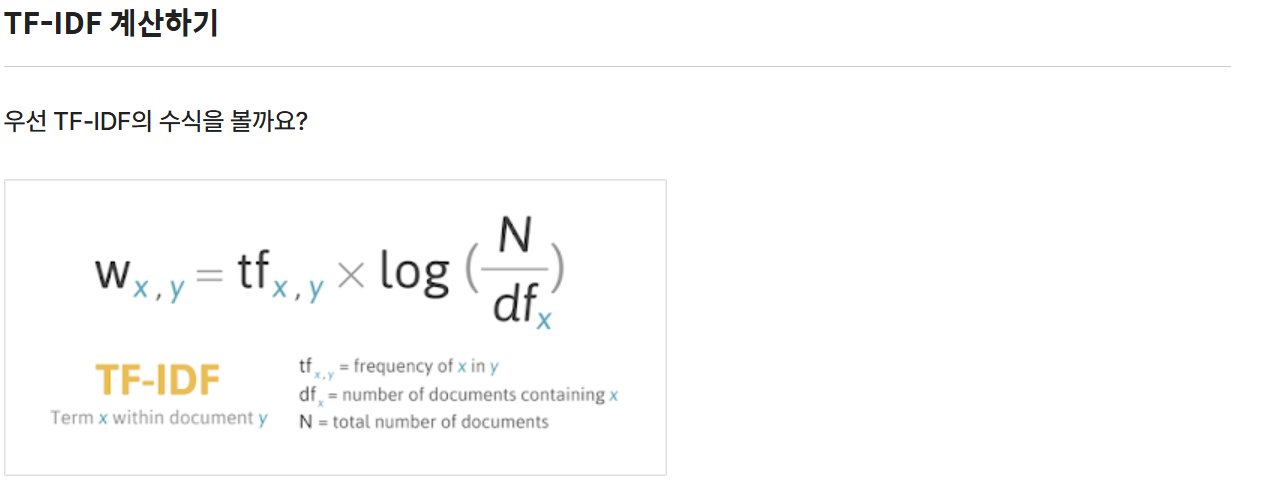

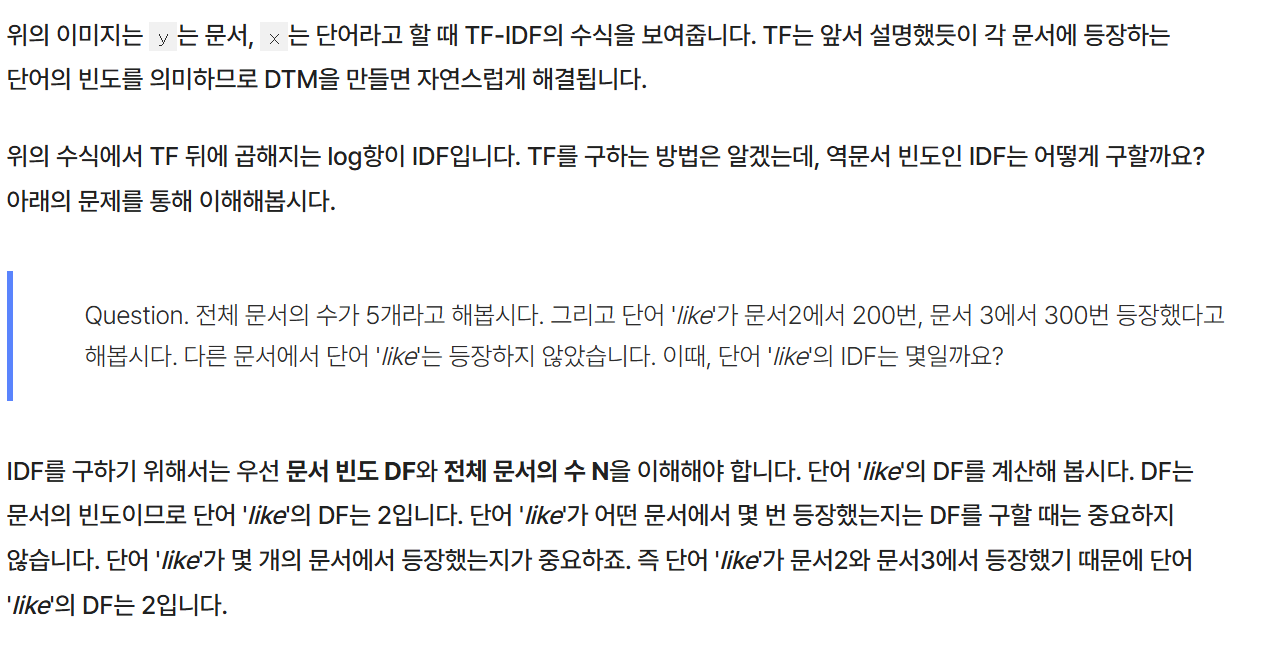

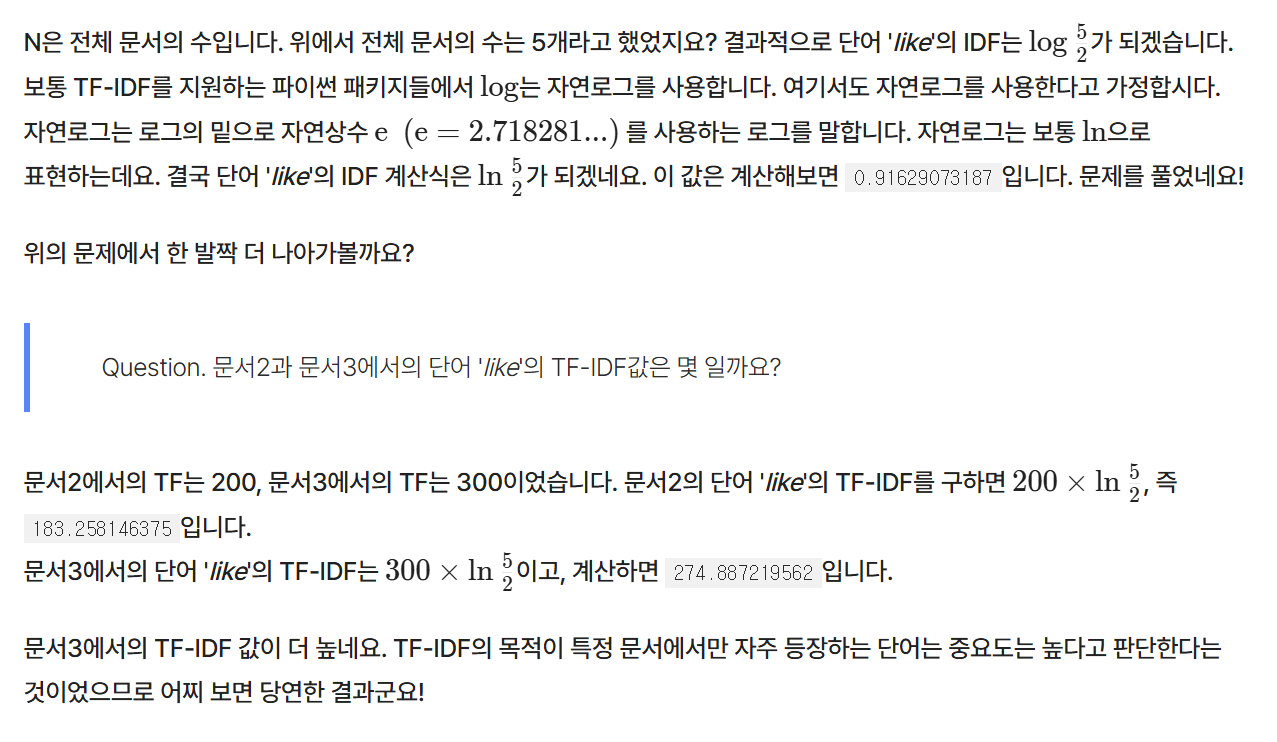

https://www.youtube.com/watch?v=Rd3OnBPDRbM

# 16-7. 단어 빈도를 이용한 벡터화 (6) TF-IDF 구현하기
## TF-IDF 구현하기
------

In [7]:

print('=3')

=3


여기서는 3개의 문서를 사용

In [8]:
docs = [
  'John likes to watch movies and Mary likes movies too',
  'James likes to watch TV',
  'Mary also likes to watch football games',  
]
print('=3')

=3


DTM의 열을 만들기 위해서 문서 3개의 단어들이 모두 들어간 통합 단어장을 만듦

In [9]:
vocab = list(set(w for doc in docs for w in doc.split()))
vocab.sort()
print('단어장의 크기 :', len(vocab))
print(vocab)

단어장의 크기 : 13
['James', 'John', 'Mary', 'TV', 'also', 'and', 'football', 'games', 'likes', 'movies', 'to', 'too', 'watch']


* 단어장의 크기는 13
* 중복을 제거한 단어들의 개수가 13개라는 의미
* 총 문서의 수를 변수 N에다가 저장

우리는 이미 이 값이 3이라는 사실을 알고 있지요?


In [10]:
N = len(docs) # 총 문서의 수
N

3

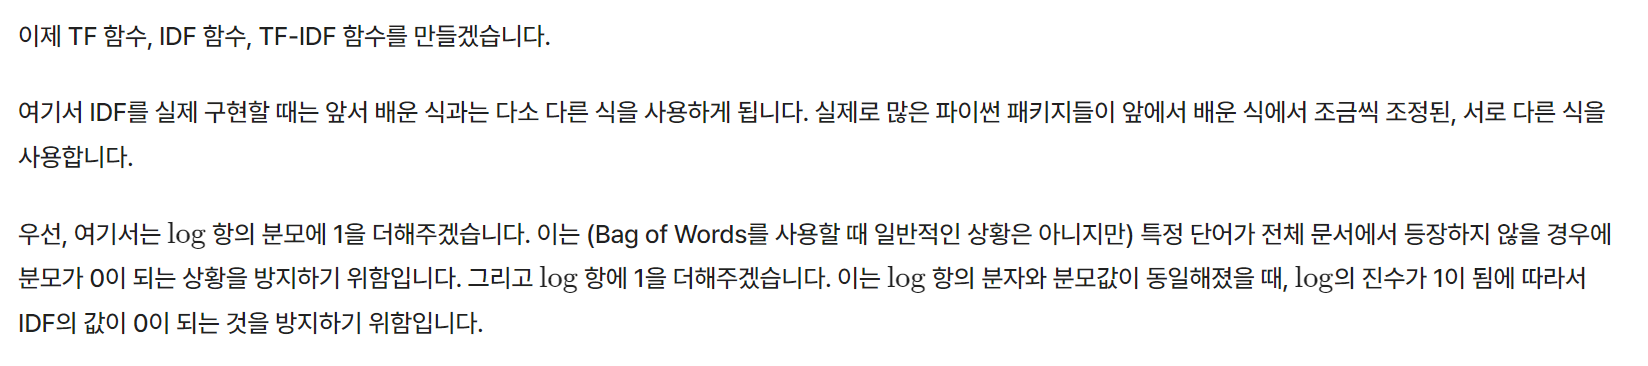

In [11]:
def tf(t, d):
    return d.count(t)
 
def idf(t):
    df = 0
    for doc in docs:
        df += t in doc    
    return log(N/(df + 1)) + 1
 
def tfidf(t, d):
    return tf(t,d)* idf(t)

TF 함수를 사용하여 DTM을 만듦

In [12]:
result = []
for i in range(N): # 각 문서에 대해서 아래 명령을 수행
    result.append([])
    d = docs[i]
    for j in range(len(vocab)):
        t = vocab[j]
        
        result[-1].append(tf(t, d))
        
tf_ = pd.DataFrame(result, columns = vocab)
tf_

,James,John,Mary,TV,also,and,football,games,likes,movies,to,too,watch
0,0,1,1,0,0,1,0,0,2,2,2,1,1
1,1,0,0,1,0,0,0,0,1,0,1,0,1
2,0,0,1,0,1,0,1,1,1,0,1,0,1


각 단어의 IDF를 구하기

In [13]:
result = []
for j in range(len(vocab)):
    t = vocab[j]
    result.append(idf(t))

idf_ = pd.DataFrame(result, index = vocab, columns=["IDF"])
idf_

,IDF
James,1.405465
John,1.405465
Mary,1.000000
TV,1.405465
also,1.405465
and,1.405465
football,1.405465
games,1.405465
likes,0.712318
movies,1.405465


IDF는 'likes'나 'to' 그리고 'watch'와 같이 모든 문서에 등장한 단어가 가장 낮은 값을 가집니다. 그리고 그다음으로 두 개의 문서에 등장한 'Mary'가 그다음으로 낮은 값을 가지며, 그 외의 1개의 문서에만 등장한 단어들은 가장 높은 값을 가지는 것을 볼 수 있습니다. 이제 TF-IDF 행렬을 출력해봅시다. DTM에 있는 각 단어의 TF에 각 단어의 IDF를 곱해준 값입니다.

In [14]:
result = []
for i in range(N):
    result.append([])
    d = docs[i]
    for j in range(len(vocab)):
        t = vocab[j]
        
        result[-1].append(tfidf(t,d))

tfidf_ = pd.DataFrame(result, columns = vocab)
tfidf_

,James,John,Mary,TV,also,and,football,games,likes,movies,to,too,watch
0,0.000000,1.405465,1.0,0.000000,0.000000,1.405465,0.000000,0.000000,1.424636,2.81093,1.424636,1.405465,0.712318
1,1.405465,0.000000,0.0,1.405465,0.000000,0.000000,0.000000,0.000000,0.712318,0.00000,0.712318,0.000000,0.712318
2,0.000000,0.000000,1.0,0.000000,1.405465,0.000000,1.405465,1.405465,0.712318,0.00000,0.712318,0.000000,0.712318


## scikit-learn TFidVectorizer 활용
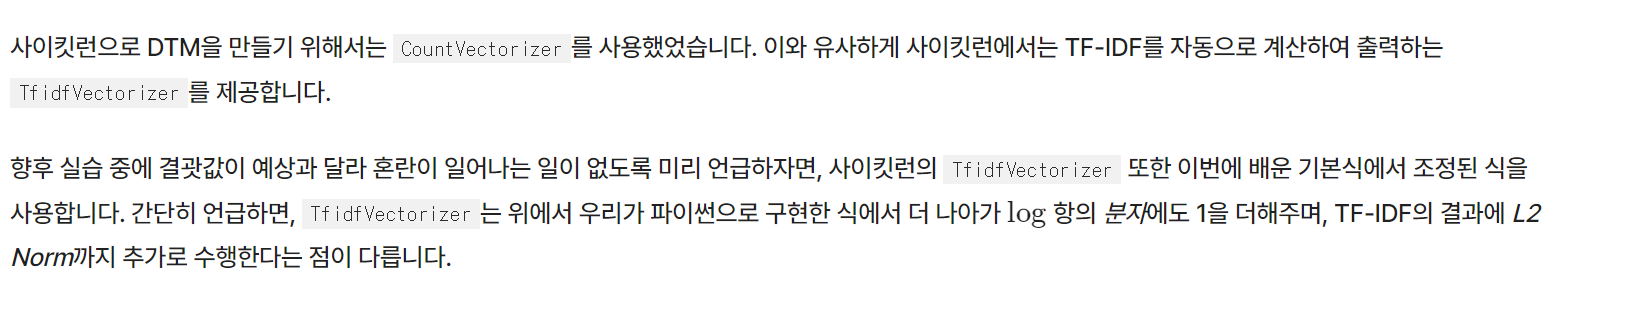

In [15]:

corpus = [
  'John likes to watch movies and Mary likes movies too',
  'James likes to watch TV',
  'Mary also likes to watch football games',  
]

tfidfv = TfidfVectorizer().fit(corpus)
vocab = list(tfidfv.vocabulary_.keys()) # 단어장을 리스트로 저장
vocab.sort() # 단어장을 알파벳 순으로 정렬

# TF-IDF 행렬에 단어장을 데이터프레임의 열로 지정하여 데이터프레임 생성
tfidf_ = pd.DataFrame(tfidfv.transform(corpus).toarray(), columns = vocab)
tfidf_

,also,and,football,games,james,john,likes,mary,movies,to,too,tv,watch
0,0.000000,0.321556,0.000000,0.000000,0.000000,0.321556,0.379832,0.244551,0.643111,0.189916,0.321556,0.000000,0.189916
1,0.000000,0.000000,0.000000,0.000000,0.572929,0.000000,0.338381,0.000000,0.000000,0.338381,0.000000,0.572929,0.338381
2,0.464997,0.000000,0.464997,0.464997,0.000000,0.000000,0.274634,0.353642,0.000000,0.274634,0.000000,0.000000,0.274634


# 16-8. LSA와 LDA (1) LSA
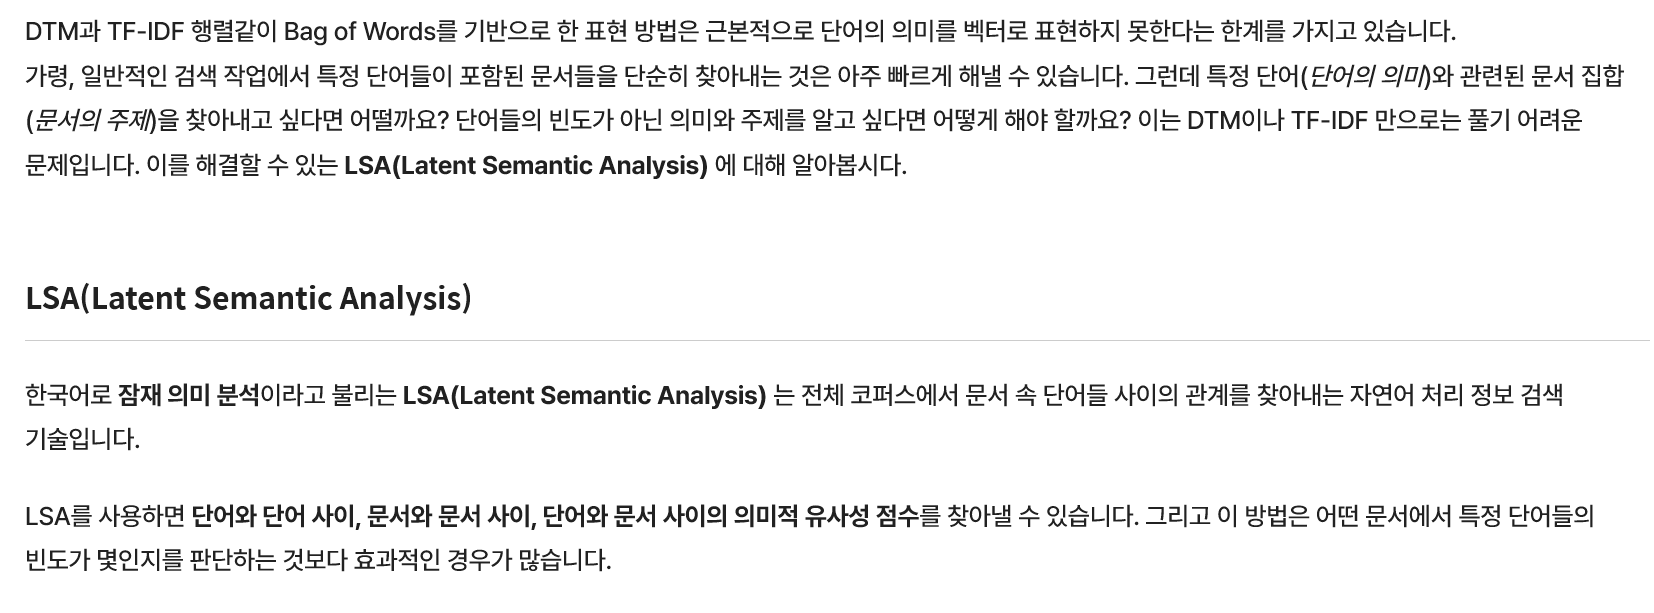
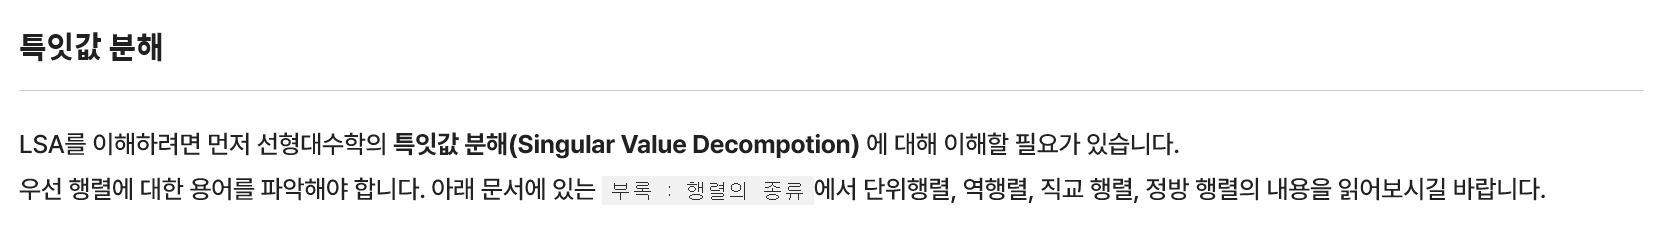

고유값 (Eigenvalue) 과 고유벡터 (Eigenvector))
https://modulabs.co.kr/blog/eigenvalue-and-eigenvector
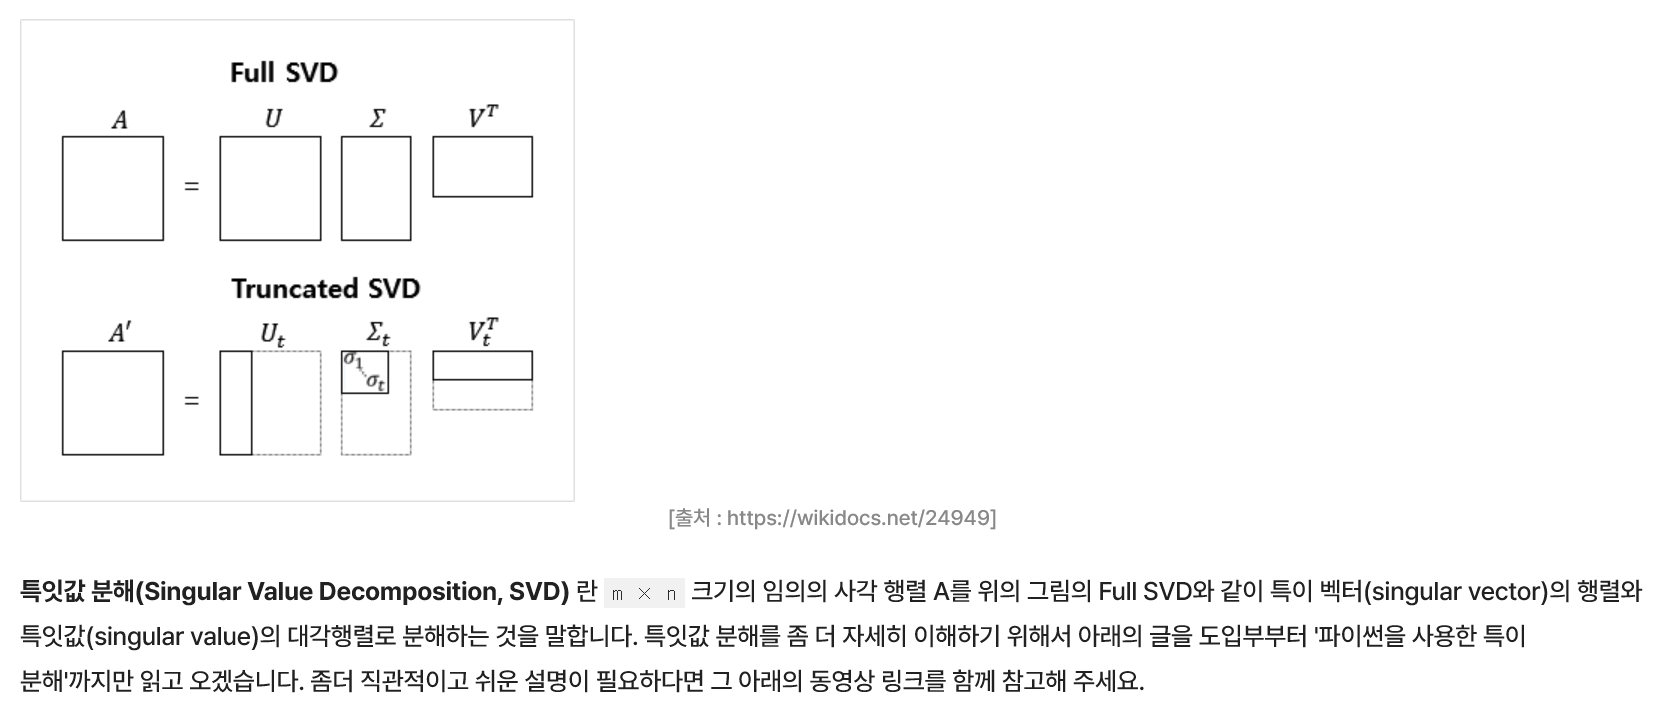

데이터 사이언스 스쿨: 특잇값 분해
https://datascienceschool.net/02%20mathematics/03.04%20%ED%8A%B9%EC%9E%87%EA%B0%92%20%EB%B6%84%ED%95%B4.html

Singular value decomposition의 목적
https://www.youtube.com/watch?v=vxJ1MzfvL5w

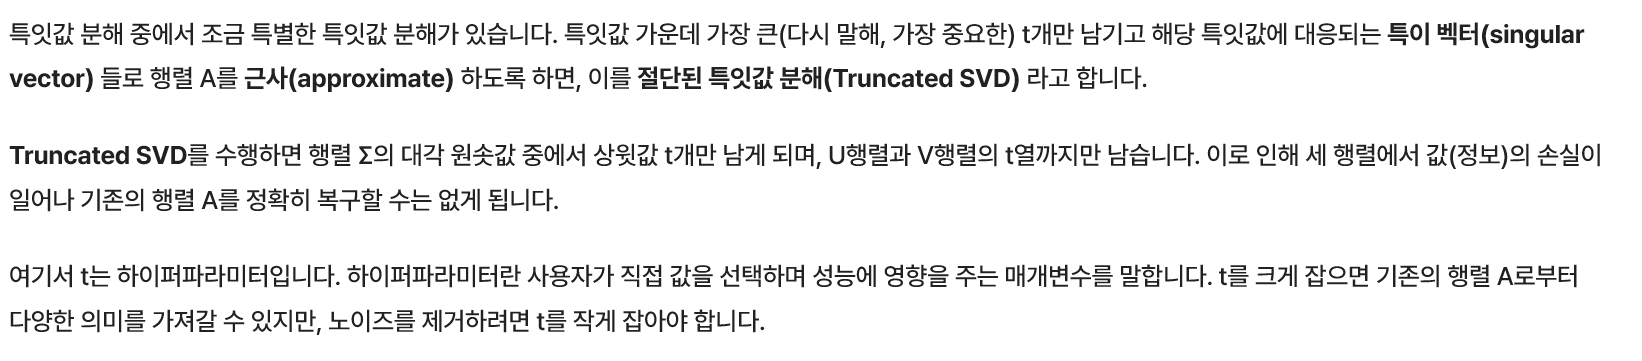

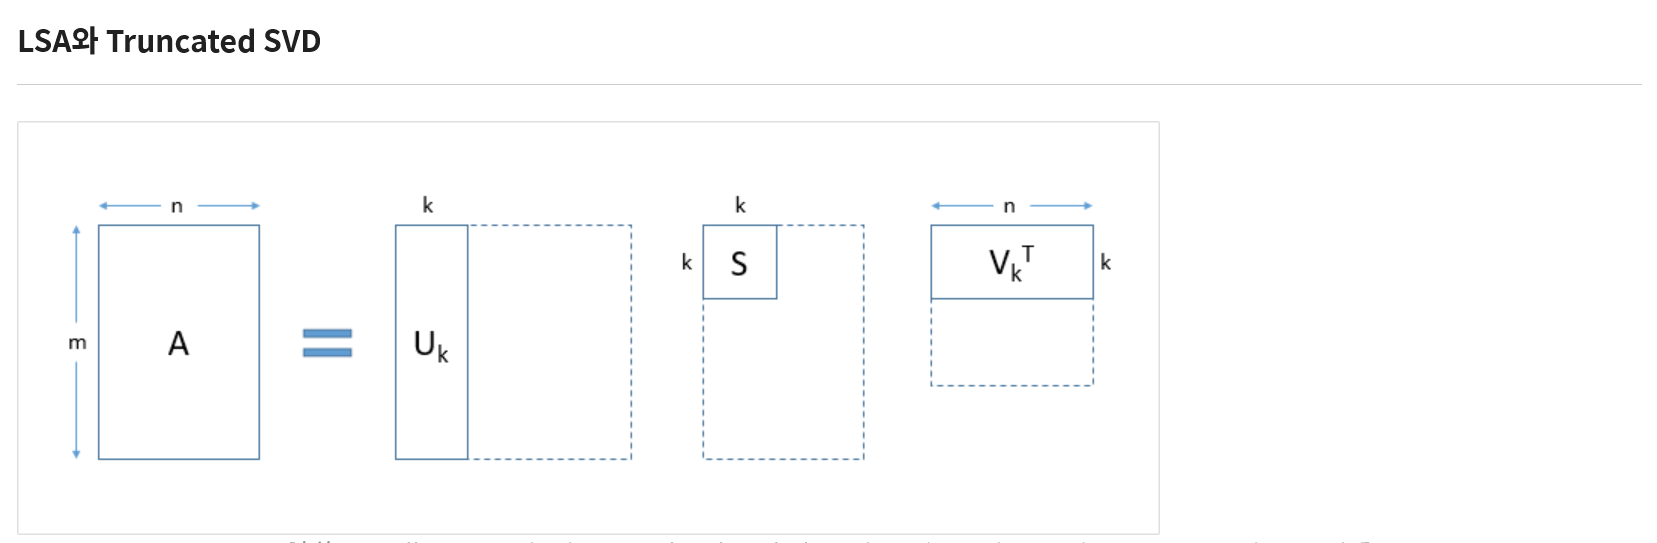

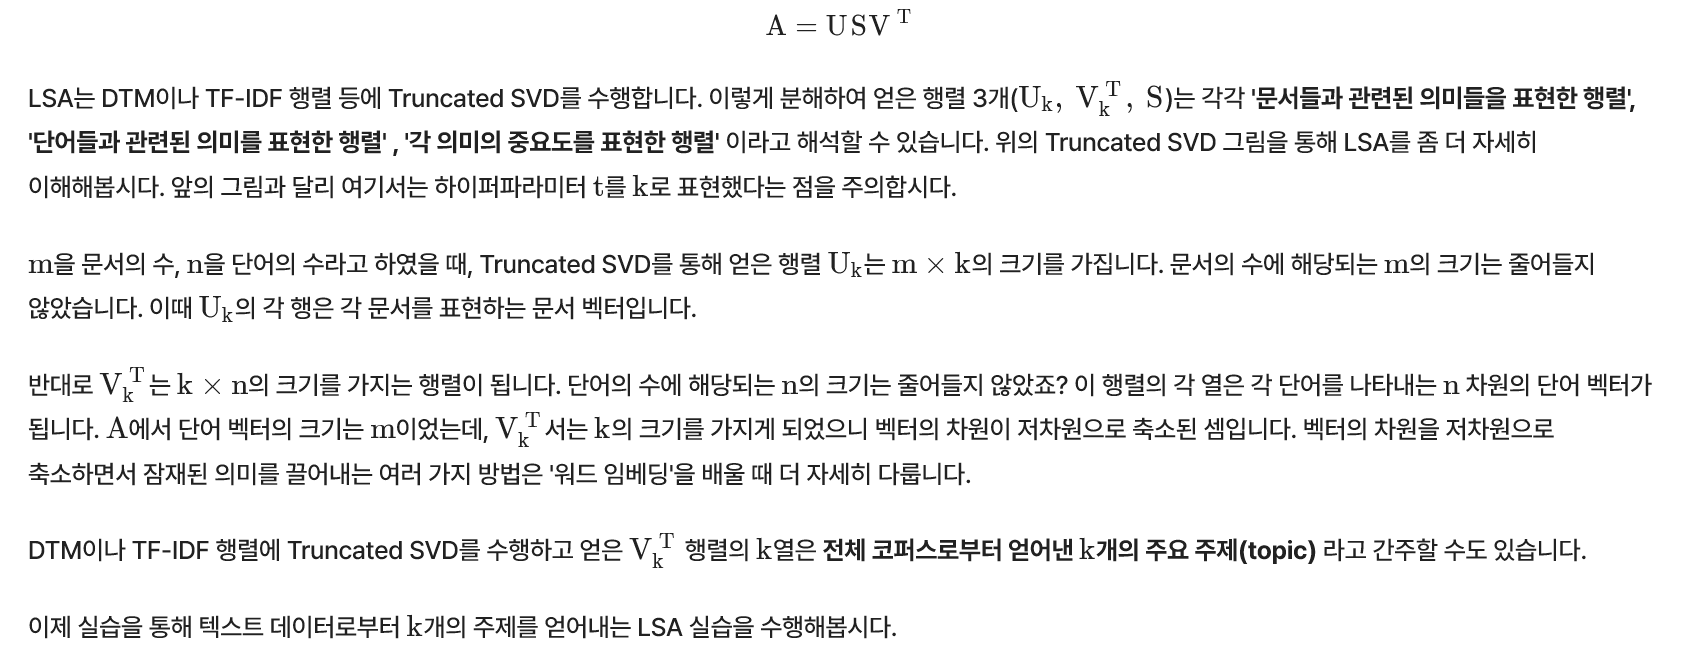

# 16-9. LSA와 LDA (2) LSA 실습

In [16]:
import pandas as pd
import numpy as np
import urllib.request
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
print('=3')

=3


NLTK 데이터셋을 다운로드하지 않은 상태라면 아래의 커맨드를 통해 다운로드해 줍니다. NLTK는 데이터셋을 다운로드해 주지 않으면 NLTK의 도구들이 제대로 동작하지 않습니다.

In [17]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /aiffel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /aiffel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 데이터 다운로드 및 확인

In [18]:
import os

csv_filename = os.getenv('HOME')+'/aiffel/topic_modelling/data/abcnews-date-text.csv'

urllib.request.urlretrieve("https://raw.githubusercontent.com/franciscadias/data/master/abcnews-date-text.csv", 
                           filename=csv_filename)

('/aiffel/aiffel/topic_modelling/data/abcnews-date-text.csv',
 <http.client.HTTPMessage at 0x7c1a6df3f5b0>)

In [19]:
data = pd.read_csv(csv_filename, on_bad_lines='skip')
data.shape
#data.head(3)

(1082168, 2)

약 108만 개의 샘플이 존재합니다. 5개의 샘플만 출력해봅시다.

In [20]:
data.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


publish_date는 이번 실습에 불필요하므로 headline_text만 별도로 저장합니다.

In [21]:
text = data[['headline_text']].copy()
text.head()

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers


In [22]:
text.nunique() # 중복을 제외하고 유일한 시퀀스를 가지는 샘플의 개수를 출력

headline_text    1054983
dtype: int64

In [23]:
text.drop_duplicates(inplace=True) # 중복 샘플 제거
text.reset_index(drop=True, inplace=True)
text.shape

(1054983, 1)

## 데이터 정제 및 정규화
이제 텍스트 데이터를 정제 및 정규화하는 과정을 진행해 보겠습니다. 우선 NLTK의 토크나이저를 이용해 전체 텍스트 데이터에 대해서 단어 토큰화를 수행하고, NLTK가 제공하는 불용어 리스트를 사용하여 불용어를 제거합니다.

아래 과정은 다소(몇 분 정도) 시간이 걸릴 수 있으니 당황하지 마세요.

In [24]:
# NLTK 토크나이저를 이용해서 토큰화
text['headline_text'] = text.apply(lambda row: nltk.word_tokenize(row['headline_text']), axis=1)

# 불용어 제거
stop_words = stopwords.words('english')
text['headline_text'] = text['headline_text'].apply(lambda x: [word for word in x if word not in (stop_words)])

text.head()

,headline_text
0,"[aba, decides, community, broadcasting, licence]"
1,"[act, fire, witnesses, must, aware, defamation]"
2,"[g, calls, infrastructure, protection, summit]"
3,"[air, nz, staff, aust, strike, pay, rise]"
4,"[air, nz, strike, affect, australian, travellers]"


이제 동일한 단어지만 다른 표현을 가지는 단어들을 하나의 단어로 통합(lemmatization)하는 단어 정규화 과정, 그리고 길이가 1 ~ 2인 단어를 제거하는 전처리를 진행합니다.

In [25]:
# 단어 정규화. 3인칭 단수 표현 -> 1인칭 변환, 과거형 동사 -> 현재형 동사 등을 수행한다.
text['headline_text'] = text['headline_text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='v') for word in x])

# 길이가 1 ~ 2인 단어는 제거.
text = text['headline_text'].apply(lambda x: [word for word in x if len(word) > 2])
print(text[:5])

0     [aba, decide, community, broadcast, licence]
1    [act, fire, witness, must, aware, defamation]
2       [call, infrastructure, protection, summit]
3            [air, staff, aust, strike, pay, rise]
4    [air, strike, affect, australian, travellers]
Name: headline_text, dtype: object


## 역토큰화 및 DTM 생성
DTM을 생성하는 CountVectorizer 또는 TF-IDF 행렬을 생성하는 TfidfVectorizer의 입력으로 사용하기 위해서 토큰화 과정을 역으로 되돌리는 역토큰화(detokenization) 를 수행해보겠습니다.

In [26]:
# 역토큰화 (토큰화 작업을 역으로 수행)
detokenized_doc = []
for i in range(len(text)):
    t = ' '.join(text[i])
    detokenized_doc.append(t)

train_data = detokenized_doc
print('=3')

=3


전처리 최종 결과는 train_data에 저장하였습니다. 5개의 샘플을 출력해봅시다.

In [27]:
train_data[:5]

['aba decide community broadcast licence',
 'act fire witness must aware defamation',
 'call infrastructure protection summit',
 'air staff aust strike pay rise',
 'air strike affect australian travellers']

전처리 최종 결과인 train_data는 다음에 배울 LDA 실습에서도 재사용 할 예정입니다. CountVectorizer를 사용하여 DTM을 생성해봅시다. 단어의 수는 5,000개로 제한하겠습니다.

In [28]:
# 상위 5000개의 단어만 사용
c_vectorizer = CountVectorizer(stop_words='english', max_features = 5000)
document_term_matrix = c_vectorizer.fit_transform(train_data)
print('=3')

=3


DTM을 생성했습니다. DTM의 크기를 확인해봅시다.

In [29]:
print('행렬의 크기 :',document_term_matrix.shape)

행렬의 크기 : (1054983, 5000)


DTM의 크기(shape)는 (문서의 수 × 단어 집합의 크기)입니다.

## scikit-learn TruncatedSVD 활용
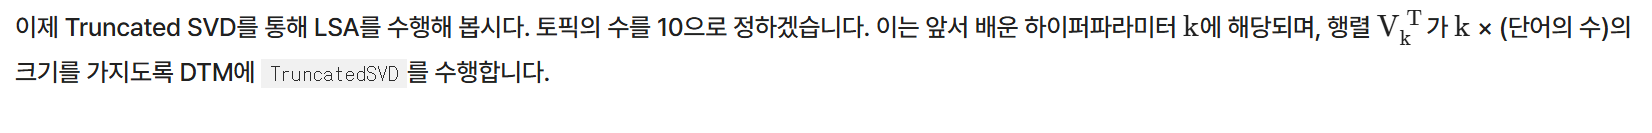

In [ ]:

n_topics = 10
lsa_model = TruncatedSVD(n_components = n_topics)
lsa_model.fit_transform(document_term_matrix)

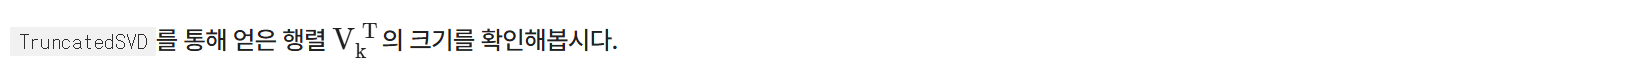

In [ ]:
print(lsa_model.components_.shape)

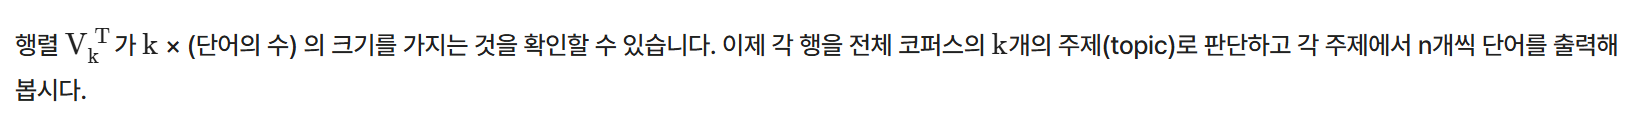

In [ ]:
terms = c_vectorizer.get_feature_names_out() # 단어 집합. 5,000개의 단어가 저장됨.

def get_topics(components, feature_names, n=5):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(5)) for i in topic.argsort()[:-n - 1:-1]])
get_topics(lsa_model.components_, terms)

# 16-10. LSA와 LDA (3) LDA
* 앞서 LSA를 통해 전체 코퍼스로부터 주요 주제인 토픽을 찾아내는 실습을 해봤습니다. 
* 이처럼 문서의 집합에서 토픽을 찾아내는 프로세스를 토픽 모델링(Topic Modelling) 이라고 함 
* 고객의 소리와 같이 많은 문서에서 주요 주제를 알아내는 일이 중요할 때 사용합니다.

### 잠재 디리클레 할당(Latent Dirichlet Allocation, LDA) 
* 토픽 모델링의 또 다른 대표적인 알고리즘
* LDA는 문서들이 토픽들의 혼합으로 구성되어 있으며, 토픽들은 확률 분포에 기반하여 단어들을 생성한다고 가정
* 데이터가 주어지면, LDA는 이 가정에 따라 단어들의 분포로부터 문서가 생성되는 과정을 역추적해 문서의 토픽을 찾아 냄

### LDA(Latent Dirichlet Allocation) 시뮬레이션

https://lettier.com/projects/lda-topic-modeling/

위의 사이트는 별도의 코드 작성 없이 입력한 문서들로부터 DTM을 만들고 LDA를 수행한 결과를 보여주는 웹 사이트입니다. 위 사이트에 접속하여 다음과 같은 순서로 시뮬레이션을 진행해 주세요.

1. '+ Add Document'를 통해 다수의 단어로 구성된 다수의 문서를 추가하세요.

2. 좌측의 'Topics'의 값을 원하는 값으로 지정해보세요. 이 값은 이 코퍼스에서 몇 개의 주제를 얻을 것인지 정하는 하이퍼파라미터값입니다.

3. 'Run LDA'를 누르고 결과로 나오는 두 개의 행렬을 확인합니다.

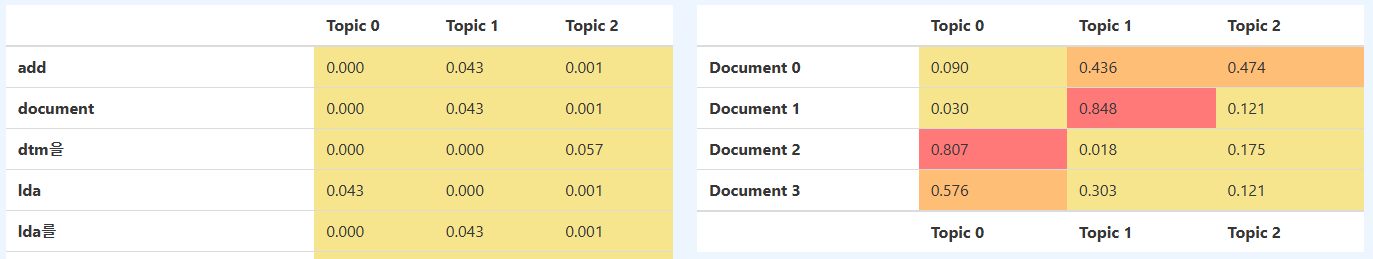

첫 번째 행렬 : 첫 번째 행렬의 행은 단어 집합의 단어들이고, 열은 Topic입니다.

두 번째 행렬 : 두 번째 행렬의 행은 문서이고, 열은 Topic입니다.

## LDA(Latent Dirichlet Allocation)의 두 가지 결과
LDA는 

* 각 토픽의 단어 분포 추정
* 각 문서의 토픽 분포 추정

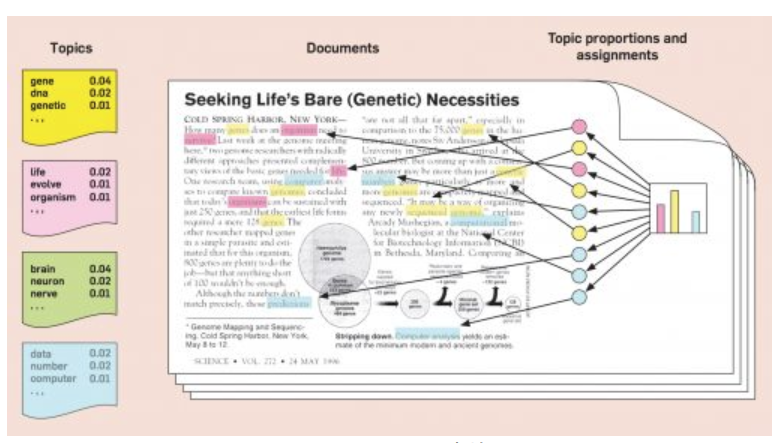

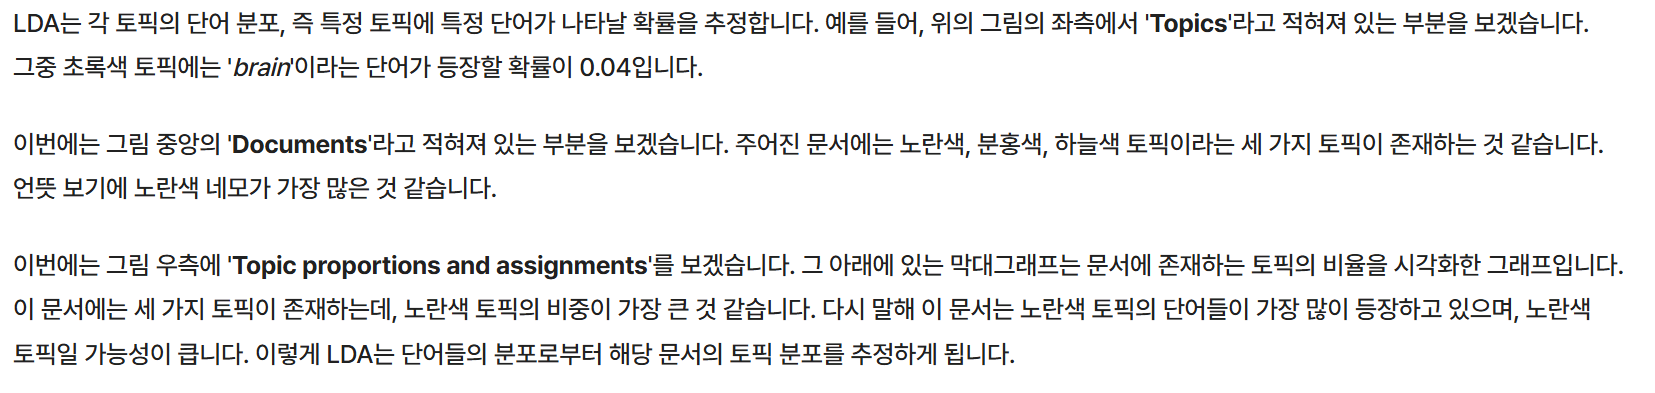

## LDA의 가정
LDA는 전체 코퍼스, 즉 다수의 문서들로부터 토픽을 뽑아내기 위해서 하나의 가정을 염두에 두고 있습니다. 모든 문서 하나, 하나가 작성될 때 그 문서의 작성자는 아래와 같은 생각을 했다는 가정입니다.


|'나는 이 문서를 작성하기 위해서 이런 주제들을 넣을거고, 이런 주제들을 위해서는 이런 단어들을 넣을 거야.'

### LDA의 직관 이해하기
https://wikidocs.net/30708  1 ~ 4번까지 읽어보는 시간


* 잠재 디리클레 할당과 잠재 의미 분석의 차이

    - LSA : DTM을 차원 축소 하여 축소 차원에서 근접 단어들을 토픽으로 묶는다.
    - LDA : 단어가 특정 토픽에 존재할 확률과 문서에 특정 토픽이 존재할 확률을 결합확률로 추정하여 토픽을 추출한다.

# 16-11. LSA와 LDA (4) LDA 실습
LDA 실습은 LSA 실습 과정에서 만들어둔 전처리가 완료된 train_data를 재사용한다고 가정합니다. 해당 데이터는 역토큰화 과정을 거친 데이터

## TF-IDF 행렬 생성
LDA는 DTM 또는 TF-IDF를 입력으로 받을 수 있습니다. 여기서는 TF-IDF를 사용하겠습니다.

TfidfVectorizer를 사용하여 TF-IDF 행렬을 생성해봅시다. 단어의 수는 5,000개로 제한하겠습니다. TF-IDF 행렬을 생성한 후에는 행렬의 크기를 확인합시다.






In [ ]:
# 상위 5,000개의 단어만 사용
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tf_idf_matrix = tfidf_vectorizer.fit_transform(train_data)

# TF-IDF 행렬의 크기를 확인해봅시다.
print('행렬의 크기 :', tf_idf_matrix.shape)

## scikit-learn LDA Model 활용


In [ ]:

lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', random_state=777, max_iter=1)
lda_model.fit_transform(tf_idf_matrix)

In [ ]:
print(lda_model.components_.shape)

전체 코퍼스로부터 얻은 10개의 토픽과 각 토픽에서의 단어의 비중을 보겠습니다.

In [ ]:
# LDA의 결과 토픽과 각 단어의 비중을 출력합시다.
terms = tfidf_vectorizer.get_feature_names_out() # 단어 집합. 5,000개의 단어가 저장됨.

def get_topics(components, feature_names, n=5):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(5)) for i in topic.argsort()[:-n-1:-1]])

get_topics(lda_model.components_, terms)

# 16-12. 텍스트 분포를 이용한 비지도 학습 토크나이저 
# (1)형태소 분석기와 단어 미등록 문제
지금까지 띄어쓰기 단위의 단어 분포를 이용해서 단어나 문서를 벡터화하는 방법에 대해 알아봤습니다. 이번에는 텍스트의 분포를 이용해서 토큰화를 수행하는 비지도 학습 토크나이저에 대해서 알아봅시다

## 형태소 분석기의 필요성
* 한국어는 교착어임.
* 교착어란? 하나의 낱말(엄밀히는 하나의 어절)이 하나의 어근(root)(혹은 어간(stem))과 각각 단일한 기능을 가지는 하나 이상의 접사(affix)의 결합으로 이루어져 있는 언어
* 조사라는 품사는 교착어에만 존재 함

이런 특성으로 인해 한국어는 영어와 달리 조사나 접사가 존재하며, 영어처럼 띄어쓰기 단위 토큰화가 제대로 동작하지 않습니다.

영어 토큰화를 복습해봅시다. 다음과 같이 영어 문장은 단순히 띄어쓰기를 수행해도 단어 토큰화가 제대로 동작합니다.

In [ ]:
en_text = "The dog ran back to the corner near the spare bedrooms"
print(en_text.split())

그런데 한국어의 경우에는 띄어쓰기 단위로 토큰화를 하면 문제가 생깁니다.

In [ ]:
kor_text = "사과의 놀라운 효능이라는 글을 봤어. 그래서 오늘 사과를 먹으려고 했는데 사과가 썩어서 슈퍼에 가서 사과랑 오렌지 사 왔어"
print(kor_text.split())

* 위의 예제 문장에서 '사과'란 단어가 총 4번 등장
* 모두 '의', '를', '가', '랑' 등이 붙어있어 이를 제거해주지 않으면 기계는 전부 다른 단어로 인식하게 됨
* 이를 해결하기 위해서 한국어는 주로 형태소 분석기를 사용 함.
** 가령, 형태소 분석기 중 하나인 Okt를 사용해서 형태소 분석을 할 경우에는 다음 결과를 얻습니다.

In [ ]:

tokenizer = Okt()
print(tokenizer.morphs(kor_text))

In [ ]:
print(tokenizer.morphs('모두의연구소에서 자연어 처리를 공부하는 건 정말 즐거워'))

'모두의연구소'는 하나의 단어이지만 위의 형태소 분석 결과에서는 전부 분리된 결과를 보여줍니다.

그렇다면 텍스트 데이터에서 특정 문자 시퀀스가 함께 자주 등장하는 빈도가 높고, 앞뒤로 조사 또는 완전히 다른 단어가 등장하는 것을 고려해서 해당 문자 시퀀스를 형태소라고 판단하는 형태소 분석기라면 어떨까요?

예를 들어, '모두의연구소'라는 문자열이 자주 연결되어 등장한다면 형태소라고 판단하고, '모두의연구소'라는 단어 앞, 뒤에 '최고', 'AI', '실력'과 같은 독립된 다른 단어들이 계속해서 등장한다면 '모두의연구소'를 형태소로 파악하는 식이지요. 이런 아이디어를 가진 형태소 분석기가 soynlp입니다.

# 16-13. 텍스트 분포를 이용한 비지도 학습 토크나이저 
# (2) soynlp
soynlp는 품사 태깅, 형태소 분석 등을 지원하는 한국어 형태소 분석기입니다.
비지도 학습으로 형태소 분석을 한다는 특징을 갖고 있으며, 데이터에 자주 등장하는 단어들을 형태소로 분석합니다.
soynlp 형태소 분석기는 내부적으로 단어 점수표로 동작합니다. 이 점수는 응집 확률(cohesion probability) 과 브랜칭 엔트로피(branching entropy) 를 활용합니다.

## soynlp 실습
soynlp 깃허브에서 제공하는 예제 말뭉치를 다운로드합니다.

In [3]:

txt_filename = os.getenv('HOME')+'/aiffel/topic_modelling/data/2016-10-20.txt'

urllib.request.urlretrieve("https://raw.githubusercontent.com/lovit/soynlp/master/tutorials/2016-10-20.txt",\
                            filename=txt_filename)

('/aiffel/aiffel/topic_modelling/data/2016-10-20.txt',
 <http.client.HTTPMessage at 0x7dd1f8544b20>)

다운로드 한 말뭉치를 문서 단위로 분리

In [4]:

# 말뭉치에 대해서 다수의 문서로 분리
corpus = DoublespaceLineCorpus(txt_filename)
len(corpus)

30091

* 총 30,091개의 문서가 존재

* 공백이 아닌 문서에 한해 상위 3개의 문서만 출력해봅시다.

In [5]:
i = 0
for document in corpus:
  if len(document) > 0:
    print(document)
    i = i+1
  if i == 3:
    break

19  1990  52 1 22
오패산터널 총격전 용의자 검거 서울 연합뉴스 경찰 관계자들이 19일 오후 서울 강북구 오패산 터널 인근에서 사제 총기를 발사해 경찰을 살해한 용의자 성모씨를 검거하고 있다 성씨는 검거 당시 서바이벌 게임에서 쓰는 방탄조끼에 헬멧까지 착용한 상태였다 독자제공 영상 캡처 연합뉴스  서울 연합뉴스 김은경 기자 사제 총기로 경찰을 살해한 범인 성모 46 씨는 주도면밀했다  경찰에 따르면 성씨는 19일 오후 강북경찰서 인근 부동산 업소 밖에서 부동산업자 이모 67 씨가 나오기를 기다렸다 이씨와는 평소에도 말다툼을 자주 한 것으로 알려졌다  이씨가 나와 걷기 시작하자 성씨는 따라가면서 미리 준비해온 사제 총기를 이씨에게 발사했다 총알이 빗나가면서 이씨는 도망갔다 그 빗나간 총알은 지나가던 행인 71 씨의 배를 스쳤다  성씨는 강북서 인근 치킨집까지 이씨 뒤를 쫓으며 실랑이하다 쓰러뜨린 후 총기와 함께 가져온 망치로 이씨 머리를 때렸다  이 과정에서 오후 6시 20분께 강북구 번동 길 위에서 사람들이 싸우고 있다 총소리가 났다 는 등의 신고가 여러건 들어왔다  5분 후에 성씨의 전자발찌가 훼손됐다는 신고가 보호관찰소 시스템을 통해 들어왔다 성범죄자로 전자발찌를 차고 있던 성씨는 부엌칼로 직접 자신의 발찌를 끊었다  용의자 소지 사제총기 2정 서울 연합뉴스 임헌정 기자 서울 시내에서 폭행 용의자가 현장 조사를 벌이던 경찰관에게 사제총기를 발사해 경찰관이 숨졌다 19일 오후 6시28분 강북구 번동에서 둔기로 맞았다 는 폭행 피해 신고가 접수돼 현장에서 조사하던 강북경찰서 번동파출소 소속 김모 54 경위가 폭행 용의자 성모 45 씨가 쏜 사제총기에 맞고 쓰러진 뒤 병원에 옮겨졌으나 숨졌다 사진은 용의자가 소지한 사제총기  신고를 받고 번동파출소에서 김창호 54 경위 등 경찰들이 오후 6시 29분께 현장으로 출동했다 성씨는 그사이 부동산 앞에 놓아뒀던 가방을 챙겨 오패산 쪽으로 도망간 후였다  김 경위는 오패산 터널 입구 오른쪽의 급경사에서 성씨에

* soynlp는 비지도학습 형태소 분석기이므로 기존의 형태소 분석기와는 달리 학습 과정을 거쳐야 함.
* 전체 코퍼스로부터 응집 확률과 브랜칭 엔트로피 단어 점수표를 만드는 과정 임
* WordExtractor.extract()를 통해서 전체 코퍼스에 대해 단어 점수표를 계산할 수 있음.

In [6]:

word_extractor = WordExtractor()
word_extractor.train(corpus)
word_score_table = word_extractor.extract()

training was done. used memory 1.117 Gb
all cohesion probabilities was computed. # words = 223348
all branching entropies was computed # words = 361598
all accessor variety was computed # words = 361598


## soynlp의 응집 확률(cohesion probability)
* 응집 확률은 내부 문자열(substring)이 얼마나 응집하여 자주 등장하는지를 판단하는 척도
* 응집 확률은 문자열을 문자 단위로 분리하여 내부 문자열을 만드는 과정에서, 왼쪽부터 순서대로 문자를 추가하면서 각 문자열이 주어졌을 때 그다음 문자가 나올 확률을 계산하여 누적 곱을 한 값이다.
* 이 값이 높을수록 전체 코퍼스에서 이 문자열 시퀀스는 하나의 단어로 등장할 가능성이 높다. 

수식은 아래
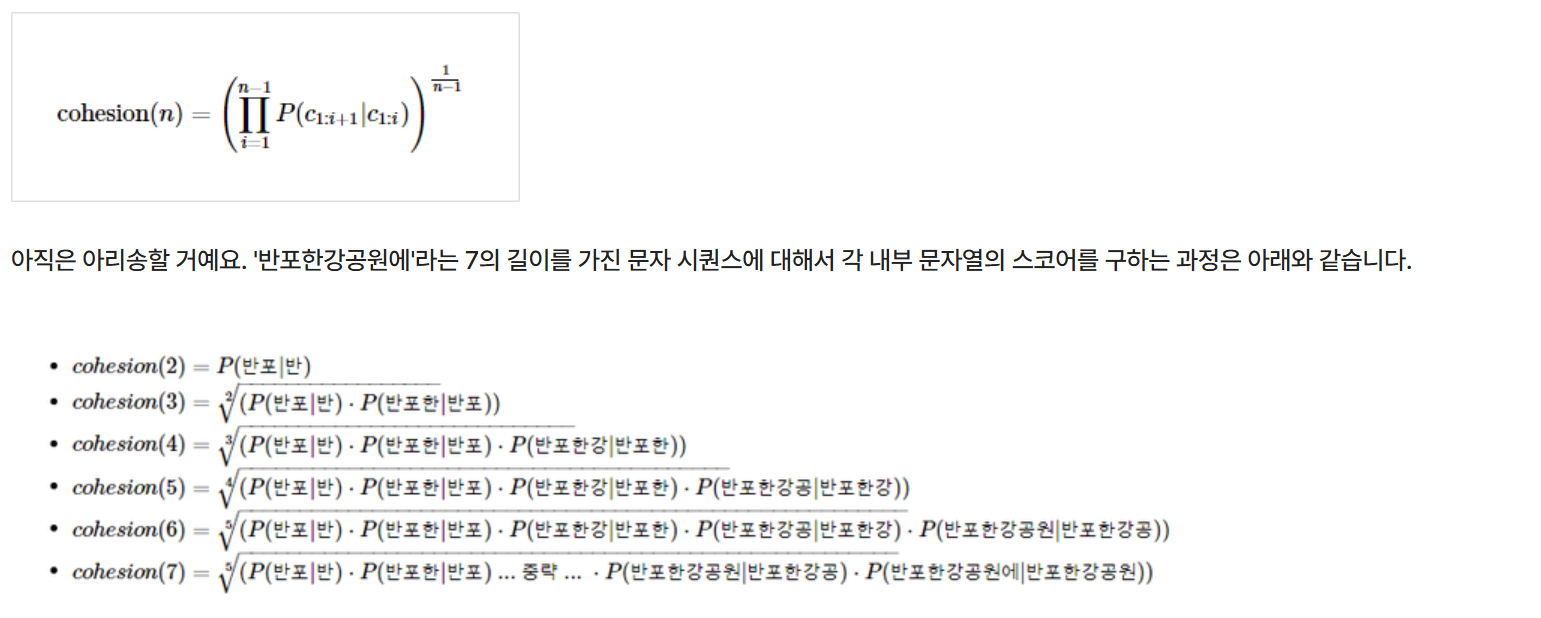

실습을 통해 직접 응집 확률 계산






In [7]:
word_score_table["반포한"].cohesion_forward

0.08838002913645132

In [8]:
word_score_table["반포한강"].cohesion_forward

0.19841268168224552

In [9]:
word_score_table["반포한강공"].cohesion_forward

0.2972877884078849

In [10]:
word_score_table["반포한강공원"].cohesion_forward

0.37891487632839754

In [11]:
word_score_table["반포한강공원에"].cohesion_forward

0.33492963377557666

응집 확률이 최대화가 되는 내부 문자열 구간은 '반포한강공원'입니다. 다시 말해 '반포한강공원'이 하나의 단어일 확률이 높습니다.

## soynlp의 브랜칭 엔트로피(branching entropy)
* 브랜칭 엔트로피(Branching Entropy) 는 확률 분포의 엔트로피값을 사용 함.
* 이는 주어진 문자열에서 다음 문자가 등장할 수 있는 가능성을 판단하는 척도



이해를 위해 퀴즈를 내보겠습니다.

제가 어떤 단어를 생각 중인데, 한 문자씩 말해드릴 테니까 매번 다음 문자를 맞추어 보세요.

첫 번째 문자는 '디'입니다. 디'로 시작하는 단어가 얼마나 많은데요. 이걸 어떻게 맞추냐구요. 정답은 '스' 입니다.

이제 '디스'까지 나왔네요. '디스' 다음 문자는 뭘까요? 벌써 정답 단어를 예측한 분도 있을 테고, 여전히 가늠이 잘 안 가시는 분도 있을 거예요. '디스카운트'라는 단어가 있으니까 '카'일까? 아니면 '디스코드'라는 단어가 있으니까 '코'인가? 생각해보니 '디스코'가 정답일 수도 있겠네요. 그러면 '코'인가? '디스아너드'라는 게임이 있으니까 '아'?

전부 땡땡땡! 이 단어들을 생각하신 분들은 전부 틀렸습니다. 정답은 '플'이었습니다.

'디스플'까지 왔습니다. 다음 문자를 맞춰보세요. 이제 좀 명백해지는군요. 이 정도 되면 헷갈리시는 분들은 거의 없을 거예요. 정답은 '레'입니다. '디스플레' 다음에는 어떤 문자일까요? 너무 명백해서 문제라고 보기도 어려워졌어요. 정답은 '이'입니다. 제가 생각한 단어는 '디스플레이'였습니다!

저는 지금 브랜칭 엔트로피를 시뮬레이션한 겁니다. 

* 브랜칭 엔트로피를 주어진 문자 시퀀스에서 다음 문자 예측을 위해 헷갈리는 정도라고 비유해 봅시다. 
* 브랜칭 엔트로피의 값은 하나의 완성된 단어에 가까워질수록 문맥으로 인해 정확히 예측할 수 있게 되므로 점차 줄어듭니다.

In [12]:
word_score_table["디스"].right_branching_entropy

1.6371694761537934

In [13]:
word_score_table["디스플"].right_branching_entropy

-0.0

디스' 다음에는 다양한 문자가 올 수 있으니까 1.63이라는 값을 가지는 반면, '디스플'이라는 문자열 다음에는 다음 문자로 '레'가 오는 것이 너무나 명백하기 때문에 0이란 값을 가집니다.

In [14]:
word_score_table["디스플레"].right_branching_entropy

-0.0

'디스플레' 다음도 마찬가지겠죠. 다음 문자가 '이'라는 사실이 너무나 명백해서 0이란 값을 가집니다. 그런데 '디스플레이' 다음에는 어떤 값을 가질까요?

In [15]:
word_score_table["디스플레이"].right_branching_entropy

3.1400392861792916

갑자기 값이 급증합니다. 그 이유는 문자 시퀀스 '디스플레이'라는 문자 시퀀스 다음에는 조사나 다른 단어가 나올 수 있는 다양한 경우가 있을 수 있기 때문입니다. 즉 하나의 단어가 끝나면 그 경계 부분부터 다시 브랜칭 엔트로피값이 증가함을 의미합니다. 그러면 이 값으로 단어를 판단하는 것이 가능하겠죠?

soynlp 패키지는 이렇게 계산한 점수를 사용해 두 가지 문자열 토큰화 방법을 제공합니다.

## soynlp의 LTokenizer
띄어쓰기 단위로 잘 나뉜 문장은 L 토크나이저(LTokenizer)를 사용하면 좋습니다.

한국어는 띄어쓰기 단위로 나눈 어절 토큰이 주로 L 토큰 + R 토큰의 형식을 가질 때가 많습니다. 예를 들어서 '공원에'는 '공원 + 에'로 나눌 수 있겠지요. 또는 '공부하는'은 '공부 + 하는'으로 나눌 수도 있을 것입니다. L 토크나이저는 L 토큰 + R 토큰으로 나누되, 점수가 가장 높은 L 토큰을 찾아내는 분리 기준을 가지고 있습니다.


In [16]:
from soynlp.tokenizer import LTokenizer

scores = {word:score.cohesion_forward for word, score in word_score_table.items()}
l_tokenizer = LTokenizer(scores=scores)
l_tokenizer.tokenize("국제사회와 우리의 노력들로 범죄를 척결하자", flatten=False)

[('국제사회', '와'), ('우리', '의'), ('노력', '들로'), ('범죄', '를'), ('척결', '하자')]

## 최대 점수 토크나이저
최대 점수 토크나이저(MaxScoreTokenizer)는 띄어쓰기가 되어 있지 않은 문장에서 점수가 높은 글자 시퀀스를 순차적으로 찾아내는 토크나이저입니다. 띄어쓰기가 되어 있지 않은 문장을 넣어서 토큰화된 결과를 점수를 통해 알아보겠습니다.

In [17]:
from soynlp.tokenizer import MaxScoreTokenizer

maxscore_tokenizer = MaxScoreTokenizer(scores=scores)
maxscore_tokenizer.tokenize("국제사회와우리의노력들로범죄를척결하자")

['국제사회', '와', '우리', '의', '노력', '들로', '범죄', '를', '척결', '하자']